### Imports

In [ ]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# other stuff

import re
from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0
There are 2 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [ ]:
!pwd

/home/local/ASUAD/abhatt43/Projects/DetectDisinfo/local_sandbox/sbp_stuff/src


### Input file with training data

In [ ]:
TYPE = "10src" ## change this as needed

data = pd.read_csv("../data/20split/full_data_"+ TYPE +".csv", usecols=[1,2,3])
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,title,content,label
0,Mumbai: 'Coronavirus heightens anxiety among v...,MUMBAI: The 2019 novel coronavirus seems to ha...,0
1,South Korea urges work from home as country re...,SEOUL: South Korea is seeking more internation...,1
2,COVID-19 and the worldview of Xi Jinping,If you thought the global crisis of World War ...,1
3,20 words & phrases that defined 2020: Hybrid,Shame. Frustration. Protest. Um-blah. Stress. ...,1
4,Pickup in Japanese business sentiment: BOJ survey,TOKYO • Japanese business sentiment improved f...,0


### Data Preprocessing

In [ ]:
#Cleaning and pre-processing

data = data[~data['content'].isna()][['title', 'content','label']]


def text_cleaning(text):
    text = re.sub("[^a-zA-Z]", " ", text) # removing punctuation
    return text

data['content'] = data['content'].apply(text_cleaning)

### Train-Test Split 

In [ ]:
#splits

train,val_test_df = train_test_split(data,test_size = 0.2)
valid, test = train_test_split(val_test_df,test_size = 0.5)

In [ ]:
valid.to_csv("./interim/valid_" + TYPE + ".csv", index=False)
train.to_csv("./interim/train_" + TYPE + ".csv", index=False)
test.to_csv("./interim/test_"+ TYPE +".csv", index=False)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### BERT Model Code

In [ ]:
# Model parameter
MAX_SEQ_LEN = 256
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('title', text_field), ('content', text_field), ('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path="./interim/", train='train_'+TYPE+'.csv', validation='valid_'+TYPE+'.csv', 
                                           test = 'test_'+TYPE+'.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.content),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.content),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, sort_key = None, batch_size=16, device=device, train=False, shuffle=False, sort=False)

/home/local/ASUAD/abhatt43/anaconda3/envs/darpa-disinfo-v1/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/local/ASUAD/abhatt43/anaconda3/envs/darpa-disinfo-v1/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/local/ASUAD/abhatt43/anaconda3/envs/darpa-disinfo-v1/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWar

In [ ]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name, num_labels=2, 
                                                                     output_attentions = False, output_hidden_states = False)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea
        
    '''def forward(self, text, label):
        loss = self.encoder(text, labels=label)[0]
        return loss
        '''

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = "./",
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (title, content, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            content = content.type(torch.LongTensor)
            content = content.to(device)
            output = model(content, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (title, content, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        content = content.type(torch.LongTensor)  
                        content = content.to(device)
                        output = model(content, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/models/' + 'model_'+TYPE+'.pt', model, best_valid_loss)
                    save_metrics(file_path + '/metrics/' + 'metrics_'+TYPE+'.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics/' + 'metrics_'+TYPE+'.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
model = BERT().to(device)
destination_folder = "."

optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [144/1440], Train Loss: 0.5845, Valid Loss: 0.4775
Model saved to ==> .//models/model_10src.pt
Model saved to ==> .//metrics/metrics_10src.pt
Epoch [1/5], Step [288/1440], Train Loss: 0.3363, Valid Loss: 2.0476
Epoch [2/5], Step [432/1440], Train Loss: 0.4797, Valid Loss: 0.4513
Model saved to ==> .//models/model_10src.pt
Model saved to ==> .//metrics/metrics_10src.pt
Epoch [2/5], Step [576/1440], Train Loss: 0.2359, Valid Loss: 2.1824
Epoch [3/5], Step [720/1440], Train Loss: 0.5287, Valid Loss: 0.4616
Epoch [3/5], Step [864/1440], Train Loss: 0.1771, Valid Loss: 2.5198
Epoch [4/5], Step [1008/1440], Train Loss: 0.4589, Valid Loss: 0.3773
Model saved to ==> .//models/model_10src.pt
Model saved to ==> .//metrics/metrics_10src.pt
Epoch [4/5], Step [1152/1440], Train Loss: 0.1171, Valid Loss: 2.1949
Epoch [5/5], Step [1296/1440], Train Loss: 0.3620, Valid Loss: 0.3965
Epoch [5/5], Step [1440/1440], Train Loss: 0.2102, Valid Loss: 1.9586
Model saved to ==> .//metrics/met

### Evaluation

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (content, labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                content = content.type(torch.LongTensor)  
                content = content.to(device)
                output = model(content, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== ./models/model_10src.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8772    0.8562    0.8666       292
           0     0.8557    0.8768    0.8661       284

    accuracy                         0.8663       576
   macro avg     0.8664    0.8665    0.8663       576
weighted avg     0.8666    0.8663    0.8663       576



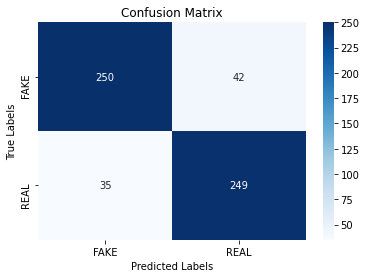

In [ ]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/models' + '/model_'+TYPE+'.pt', best_model)
evaluate(best_model, test_iter)